In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


## Now I'm plugging my own dataset 

In [3]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

# Pay attention to executing the right cell for the desired experiment.

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


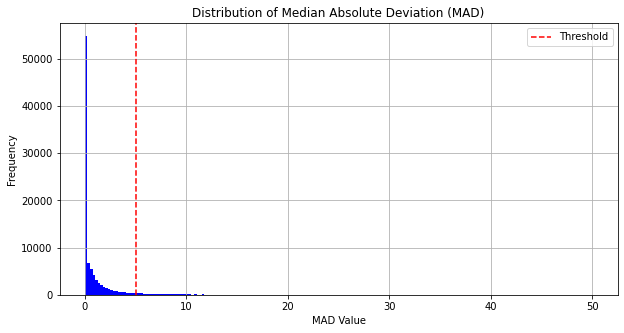

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [2]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


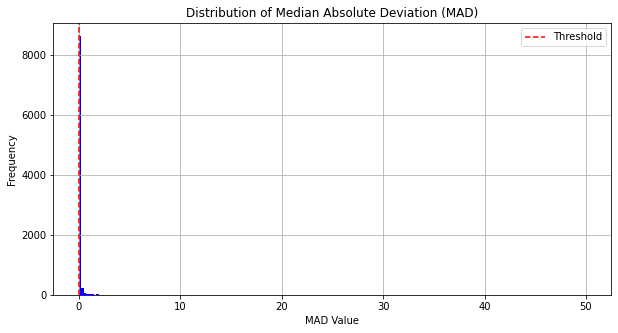

removing 6876 genes under the MAD threshold from the dataset
number of genes selected :  2185
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [4]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

In [ ]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)


# End of experiment choice

In [5]:
data = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

In [6]:
# adding my own labels :

metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
num_classes = len(pd.Series(label).unique())

back to the regular notebook

In [7]:
dat = pd.DataFrame(data)
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(4445, 1, 2185)


In [8]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [9]:
train_data, test_data = train_test_split(dat, test_size = 0.3,random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=False)

train data: 3111
test data: 1334


In [10]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for m1 mac
DEVICE = torch.device("mps")

out_dim = 512   
VQ_VAE = Model(
            dropout = 0.0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 64,  
            embedding_dim = 64,   
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-3, amsgrad=False)
data_variance = np.var(dat)

print(DEVICE)

mps


Added feature to monitor training


  0%|          | 1/200 [00:02<07:02,  2.12s/it]

Epoch 1/200, Training Loss: 1.1370853690000682, Validation Loss: 0.9747612738893146


  1%|          | 2/200 [00:02<04:07,  1.25s/it]

Epoch 2/200, Training Loss: 5.128021185214703, Validation Loss: 17.192924771990096


  2%|▏         | 3/200 [00:03<03:12,  1.02it/s]

Epoch 3/200, Training Loss: 23.90158878839933, Validation Loss: 73.39650022699719


  2%|▏         | 4/200 [00:03<02:41,  1.22it/s]

Epoch 4/200, Training Loss: 45.39577915118291, Validation Loss: 25.53276398352214


  2%|▎         | 5/200 [00:04<02:26,  1.33it/s]

Epoch 5/200, Training Loss: 9.73116687627939, Validation Loss: 7.002675150121961


  3%|▎         | 6/200 [00:05<02:16,  1.43it/s]

Epoch 6/200, Training Loss: 15.834966274408194, Validation Loss: 26.881040258066996


  4%|▎         | 7/200 [00:05<02:08,  1.50it/s]

Epoch 7/200, Training Loss: 10.463682743219229, Validation Loss: 1.389387431598845


  4%|▍         | 8/200 [00:06<02:05,  1.53it/s]

Epoch 8/200, Training Loss: 10.326491961112389, Validation Loss: 26.62133264612584


  4%|▍         | 9/200 [00:07<02:02,  1.56it/s]

Epoch 9/200, Training Loss: 10.232757793023037, Validation Loss: 1.0550178282317662


  5%|▌         | 10/200 [00:07<01:59,  1.59it/s]

Epoch 10/200, Training Loss: 0.5182298857432145, Validation Loss: 0.5473523026420957


  6%|▌         | 11/200 [00:08<01:56,  1.62it/s]

Epoch 11/200, Training Loss: 12.030554134112139, Validation Loss: 12.33409493310111


  6%|▌         | 12/200 [00:08<01:55,  1.62it/s]

Epoch 12/200, Training Loss: 3.3259997367858887, Validation Loss: 1.0956284127065115


  6%|▋         | 13/200 [00:09<01:54,  1.63it/s]

Epoch 13/200, Training Loss: 5.906269137675945, Validation Loss: 2.7728014354194914


  7%|▋         | 14/200 [00:10<01:53,  1.64it/s]

Epoch 14/200, Training Loss: 7.687538146972656, Validation Loss: 3.4025149196386337


  8%|▊         | 15/200 [00:10<01:52,  1.65it/s]

Epoch 15/200, Training Loss: 3.008844453554887, Validation Loss: 0.34899316302367617


  8%|▊         | 16/200 [00:11<01:51,  1.66it/s]

Epoch 16/200, Training Loss: 5.829067890460674, Validation Loss: 8.744876213016964


  8%|▊         | 17/200 [00:11<01:51,  1.64it/s]

Epoch 17/200, Training Loss: 2.4782818326583276, Validation Loss: 0.4122484205734162


  9%|▉         | 18/200 [00:12<01:50,  1.65it/s]

Epoch 18/200, Training Loss: 3.725713564799382, Validation Loss: 11.420078092032956


 10%|▉         | 19/200 [00:13<01:48,  1.66it/s]

Epoch 19/200, Training Loss: 5.966718675998541, Validation Loss: 0.3740562094109399


 10%|█         | 20/200 [00:13<01:48,  1.66it/s]

Epoch 20/200, Training Loss: 0.4016226530075073, Validation Loss: 0.37006428341070813


 10%|█         | 21/200 [00:14<01:47,  1.67it/s]

Epoch 21/200, Training Loss: 8.512671353725286, Validation Loss: 13.268814734759784


 11%|█         | 22/200 [00:14<01:47,  1.66it/s]

Epoch 22/200, Training Loss: 4.221482799603389, Validation Loss: 0.6863065702574593


 12%|█▏        | 23/200 [00:15<01:45,  1.67it/s]

Epoch 23/200, Training Loss: 0.8793875804314246, Validation Loss: 2.102171683595294


 12%|█▏        | 24/200 [00:16<01:45,  1.67it/s]

Epoch 24/200, Training Loss: 9.794351499814253, Validation Loss: 1.7118261484872728


 12%|█▎        | 25/200 [00:16<01:47,  1.63it/s]

Epoch 25/200, Training Loss: 1.2979254951843848, Validation Loss: 0.7462244360219865


 13%|█▎        | 26/200 [00:17<01:46,  1.63it/s]

Epoch 26/200, Training Loss: 1.0622398990851183, Validation Loss: 4.905217241673243


 14%|█▎        | 27/200 [00:17<01:45,  1.65it/s]

Epoch 27/200, Training Loss: 6.063474554281968, Validation Loss: 2.5299299983751204


 14%|█▍        | 28/200 [00:18<01:44,  1.65it/s]

Epoch 28/200, Training Loss: 4.518335058138921, Validation Loss: 17.48543745137396


 14%|█▍        | 29/200 [00:19<01:43,  1.66it/s]

Epoch 29/200, Training Loss: 4.567033886909485, Validation Loss: 1.1793462009656996


 15%|█▌        | 30/200 [00:19<01:42,  1.66it/s]

Epoch 30/200, Training Loss: 1.531049253848883, Validation Loss: 1.8553598015790893


 16%|█▌        | 31/200 [00:20<01:42,  1.65it/s]

Epoch 31/200, Training Loss: 5.566764272176302, Validation Loss: 1.0630375590352785


 16%|█▌        | 32/200 [00:20<01:41,  1.65it/s]

Epoch 32/200, Training Loss: 1.1839174788731794, Validation Loss: 0.45814503268116996


 16%|█▋        | 33/200 [00:21<01:42,  1.63it/s]

Epoch 33/200, Training Loss: 4.398641538161498, Validation Loss: 1.2882493028328532


 17%|█▋        | 34/200 [00:22<01:41,  1.64it/s]

Epoch 34/200, Training Loss: 0.6304885538724753, Validation Loss: 0.6264550636212031


 18%|█▊        | 35/200 [00:22<01:39,  1.65it/s]

Epoch 35/200, Training Loss: 0.6423295942636637, Validation Loss: 0.5876933754909606


 18%|█▊        | 36/200 [00:23<01:38,  1.66it/s]

Epoch 36/200, Training Loss: 0.8203328412312728, Validation Loss: 0.736673809942745


 18%|█▊        | 37/200 [00:23<01:37,  1.67it/s]

Epoch 37/200, Training Loss: 1.6059397504879878, Validation Loss: 1.0995229794865562


 19%|█▉        | 38/200 [00:24<01:36,  1.67it/s]

Epoch 38/200, Training Loss: 1.765171413238232, Validation Loss: 0.8302730392842066


 20%|█▉        | 39/200 [00:25<01:35,  1.68it/s]

Epoch 39/200, Training Loss: 1.4929026434054742, Validation Loss: 0.602537377959206


 20%|██        | 40/200 [00:25<01:35,  1.67it/s]

Epoch 40/200, Training Loss: 1.7369439189250653, Validation Loss: 1.227281392330215


 20%|██        | 41/200 [00:26<01:36,  1.65it/s]

Epoch 41/200, Training Loss: 3.097894861147954, Validation Loss: 8.446496394418535


 21%|██        | 42/200 [00:26<01:35,  1.65it/s]

Epoch 42/200, Training Loss: 6.815558470212496, Validation Loss: 2.311687238869213


 22%|██▏       | 43/200 [00:27<01:34,  1.66it/s]

Epoch 43/200, Training Loss: 2.296706339487663, Validation Loss: 3.919704604716528


 22%|██▏       | 44/200 [00:28<01:33,  1.67it/s]

Epoch 44/200, Training Loss: 1.3799094626536736, Validation Loss: 3.3116097208999453


 22%|██▎       | 45/200 [00:28<01:36,  1.60it/s]

Epoch 45/200, Training Loss: 1.36617806324592, Validation Loss: 0.8414529526517505


 23%|██▎       | 46/200 [00:29<01:39,  1.55it/s]

Epoch 46/200, Training Loss: 2.36168864598641, Validation Loss: 1.4926299637272245


 24%|██▎       | 47/200 [00:30<01:36,  1.58it/s]

Epoch 47/200, Training Loss: 0.6347001515902005, Validation Loss: 0.42402498991716475


 24%|██▍       | 48/200 [00:30<01:34,  1.60it/s]

Epoch 48/200, Training Loss: 0.38890202458088213, Validation Loss: 0.35364759110269095


 24%|██▍       | 49/200 [00:31<01:36,  1.56it/s]

Epoch 49/200, Training Loss: 0.3682717039034917, Validation Loss: 0.42226002862056095


 25%|██▌       | 50/200 [00:32<01:39,  1.50it/s]

Epoch 50/200, Training Loss: 0.4231127156661107, Validation Loss: 0.45850510043757303


 26%|██▌       | 51/200 [00:32<01:36,  1.55it/s]

Epoch 51/200, Training Loss: 0.7177039224367875, Validation Loss: 1.149096056818962


 26%|██▌       | 52/200 [00:33<01:33,  1.58it/s]

Epoch 52/200, Training Loss: 0.5853732297053704, Validation Loss: 0.41359358174460276


 26%|██▋       | 53/200 [00:33<01:31,  1.61it/s]

Epoch 53/200, Training Loss: 0.7409747449251322, Validation Loss: 0.608572067249389


 27%|██▋       | 54/200 [00:34<01:30,  1.61it/s]

Epoch 54/200, Training Loss: 0.46664942227877104, Validation Loss: 0.35561840661934446


 28%|██▊       | 55/200 [00:35<01:29,  1.63it/s]

Epoch 55/200, Training Loss: 0.3705936555679028, Validation Loss: 0.4319554915030797


 28%|██▊       | 56/200 [00:35<01:27,  1.64it/s]

Epoch 56/200, Training Loss: 0.4044316823665912, Validation Loss: 0.4187638784448306


 28%|██▊       | 57/200 [00:36<01:27,  1.63it/s]

Epoch 57/200, Training Loss: 0.5308625079118289, Validation Loss: 0.3694951484600703


 29%|██▉       | 58/200 [00:37<01:27,  1.63it/s]

Epoch 58/200, Training Loss: 0.40474732564045834, Validation Loss: 0.3421047187986828


 30%|██▉       | 59/200 [00:37<01:26,  1.63it/s]

Epoch 59/200, Training Loss: 0.3606107968550462, Validation Loss: 0.3348391258290836


 30%|███       | 60/200 [00:38<01:25,  1.63it/s]

Epoch 60/200, Training Loss: 0.3433289871766017, Validation Loss: 0.3155115019707453


 30%|███       | 61/200 [00:38<01:24,  1.64it/s]

Epoch 61/200, Training Loss: 0.33697258623746723, Validation Loss: 0.30643813418490545


 31%|███       | 62/200 [00:39<01:23,  1.65it/s]

Epoch 62/200, Training Loss: 0.3434268648807819, Validation Loss: 0.3242782563680694


 32%|███▏      | 63/200 [00:40<01:23,  1.65it/s]

Epoch 63/200, Training Loss: 0.37274908331724316, Validation Loss: 0.3497932290747052


 32%|███▏      | 64/200 [00:40<01:22,  1.65it/s]

Epoch 64/200, Training Loss: 0.39164159618891203, Validation Loss: 0.3656463725935845


 32%|███▎      | 65/200 [00:41<01:21,  1.66it/s]

Epoch 65/200, Training Loss: 0.4341930471933805, Validation Loss: 0.3501456904978979


 33%|███▎      | 66/200 [00:41<01:21,  1.64it/s]

Epoch 66/200, Training Loss: 0.3770324496122507, Validation Loss: 0.40635103164684205


 34%|███▎      | 67/200 [00:42<01:20,  1.65it/s]

Epoch 67/200, Training Loss: 0.5000531467107626, Validation Loss: 1.4267796849211056


 34%|███▍      | 68/200 [00:43<01:20,  1.64it/s]

Epoch 68/200, Training Loss: 0.9366172208235815, Validation Loss: 0.3513659402018502


 34%|███▍      | 69/200 [00:43<01:19,  1.66it/s]

Epoch 69/200, Training Loss: 0.40630900401335496, Validation Loss: 0.43330636904353187


 35%|███▌      | 70/200 [00:44<01:18,  1.65it/s]

Epoch 70/200, Training Loss: 0.44445542418039763, Validation Loss: 0.3718074978817077


 36%|███▌      | 71/200 [00:44<01:17,  1.66it/s]

Epoch 71/200, Training Loss: 0.34390339255332947, Validation Loss: 0.3382102389420782


 36%|███▌      | 72/200 [00:45<01:17,  1.66it/s]

Epoch 72/200, Training Loss: 0.36064567932715785, Validation Loss: 0.32695547455833074


 36%|███▋      | 73/200 [00:46<01:16,  1.66it/s]

Epoch 73/200, Training Loss: 0.3302520834482633, Validation Loss: 0.296172990330628


 37%|███▋      | 74/200 [00:46<01:16,  1.64it/s]

Epoch 74/200, Training Loss: 0.3021599787932176, Validation Loss: 0.33386606226364773


 38%|███▊      | 75/200 [00:47<01:16,  1.64it/s]

Epoch 75/200, Training Loss: 0.31502392888069153, Validation Loss: 0.3191208363998504


 38%|███▊      | 76/200 [00:47<01:15,  1.65it/s]

Epoch 76/200, Training Loss: 0.3440423940236752, Validation Loss: 0.30612346636397497


 38%|███▊      | 77/200 [00:48<01:14,  1.66it/s]

Epoch 77/200, Training Loss: 0.3137570046461545, Validation Loss: 0.3167328174625124


 39%|███▉      | 78/200 [00:49<01:13,  1.67it/s]

Epoch 78/200, Training Loss: 0.3162950369027945, Validation Loss: 0.29140436081659227


 40%|███▉      | 79/200 [00:49<01:13,  1.65it/s]

Epoch 79/200, Training Loss: 0.3095963207574991, Validation Loss: 0.31295228465681985


 40%|████      | 80/200 [00:50<01:12,  1.66it/s]

Epoch 80/200, Training Loss: 0.316964049751942, Validation Loss: 0.3043359734472774


 40%|████      | 81/200 [00:50<01:11,  1.66it/s]

Epoch 81/200, Training Loss: 0.31311132586919344, Validation Loss: 0.29712418750638053


 41%|████      | 82/200 [00:51<01:12,  1.64it/s]

Epoch 82/200, Training Loss: 0.3170092564362746, Validation Loss: 0.3060353753112611


 42%|████▏     | 83/200 [00:52<01:11,  1.64it/s]

Epoch 83/200, Training Loss: 0.3046086591023665, Validation Loss: 0.2917076909825915


 42%|████▏     | 84/200 [00:52<01:10,  1.65it/s]

Epoch 84/200, Training Loss: 0.3229981569143442, Validation Loss: 0.3190081555928503


 42%|████▎     | 85/200 [00:53<01:09,  1.66it/s]

Epoch 85/200, Training Loss: 0.3528039799286769, Validation Loss: 0.2902492636016437


 43%|████▎     | 86/200 [00:53<01:08,  1.66it/s]

Epoch 86/200, Training Loss: 0.29262438874978286, Validation Loss: 0.29208391691957203


 44%|████▎     | 87/200 [00:54<01:08,  1.65it/s]

Epoch 87/200, Training Loss: 0.291796468771421, Validation Loss: 0.29338194749185015


 44%|████▍     | 88/200 [00:55<01:07,  1.66it/s]

Epoch 88/200, Training Loss: 0.3088592669138542, Validation Loss: 0.31851845553943087


 44%|████▍     | 89/200 [00:55<01:06,  1.66it/s]

Epoch 89/200, Training Loss: 0.3562162976998549, Validation Loss: 0.31336579294431777


 45%|████▌     | 90/200 [00:56<01:06,  1.66it/s]

Epoch 90/200, Training Loss: 0.3024302675173833, Validation Loss: 0.27298018691085635


 46%|████▌     | 91/200 [00:56<01:06,  1.65it/s]

Epoch 91/200, Training Loss: 0.305704428599431, Validation Loss: 0.29405179655268077


 46%|████▌     | 92/200 [00:57<01:05,  1.66it/s]

Epoch 92/200, Training Loss: 0.33288034338217515, Validation Loss: 0.3140929791898954


 46%|████▋     | 93/200 [00:58<01:04,  1.66it/s]

Epoch 93/200, Training Loss: 0.29642422382648176, Validation Loss: 0.2717981810371081


 47%|████▋     | 94/200 [00:58<01:04,  1.65it/s]

Epoch 94/200, Training Loss: 0.2836675070799314, Validation Loss: 0.2828433612982432


 48%|████▊     | 95/200 [00:59<01:03,  1.65it/s]

Epoch 95/200, Training Loss: 0.37436540310199445, Validation Loss: 0.31492972728751956


 48%|████▊     | 96/200 [01:00<01:03,  1.65it/s]

Epoch 96/200, Training Loss: 0.2952418694129357, Validation Loss: 0.26899485467445283


 48%|████▊     | 97/200 [01:00<01:02,  1.66it/s]

Epoch 97/200, Training Loss: 0.2810766238432664, Validation Loss: 0.27588808075303123


 49%|████▉     | 98/200 [01:01<01:01,  1.67it/s]

Epoch 98/200, Training Loss: 0.29425475689081043, Validation Loss: 0.3028747531629744


 50%|████▉     | 99/200 [01:01<01:01,  1.64it/s]

Epoch 99/200, Training Loss: 0.3083847165107727, Validation Loss: 0.28355916483061655


 50%|█████     | 100/200 [01:02<01:00,  1.65it/s]

Epoch 100/200, Training Loss: 0.29552229321919954, Validation Loss: 0.2794989695151647


 50%|█████     | 101/200 [01:03<00:59,  1.66it/s]

Epoch 101/200, Training Loss: 0.2967799065204767, Validation Loss: 0.2819501782457034


 51%|█████     | 102/200 [01:03<00:58,  1.66it/s]

Epoch 102/200, Training Loss: 0.29896072355600506, Validation Loss: 0.27421209890218007


 52%|█████▏    | 103/200 [01:04<00:58,  1.67it/s]

Epoch 103/200, Training Loss: 0.283611529148542, Validation Loss: 0.2743868753314018


 52%|█████▏    | 104/200 [01:04<00:57,  1.67it/s]

Epoch 104/200, Training Loss: 0.29490457704434025, Validation Loss: 0.2753422863426663


 52%|█████▎    | 105/200 [01:05<00:57,  1.66it/s]

Epoch 105/200, Training Loss: 0.28742285989798033, Validation Loss: 0.2747240744176365


 53%|█████▎    | 106/200 [01:06<00:56,  1.67it/s]

Epoch 106/200, Training Loss: 0.2936805200118285, Validation Loss: 0.2799488554398219


 54%|█████▎    | 107/200 [01:06<00:56,  1.65it/s]

Epoch 107/200, Training Loss: 0.2840381700258989, Validation Loss: 0.270355248380275


 54%|█████▍    | 108/200 [01:07<00:55,  1.65it/s]

Epoch 108/200, Training Loss: 0.29008585329239184, Validation Loss: 0.291000349181039


 55%|█████▍    | 109/200 [01:07<00:54,  1.66it/s]

Epoch 109/200, Training Loss: 0.2955006853892253, Validation Loss: 0.27784439140842077


 55%|█████▌    | 110/200 [01:08<00:53,  1.67it/s]

Epoch 110/200, Training Loss: 0.28640896998918974, Validation Loss: 0.2725619503429958


 56%|█████▌    | 111/200 [01:09<00:53,  1.67it/s]

Epoch 111/200, Training Loss: 0.2952827788316287, Validation Loss: 0.2768114720072065


 56%|█████▌    | 112/200 [01:09<00:52,  1.67it/s]

Epoch 112/200, Training Loss: 0.28420548943372875, Validation Loss: 0.2683064600541478


 56%|█████▋    | 113/200 [01:10<00:52,  1.67it/s]

Epoch 113/200, Training Loss: 0.28355125051278335, Validation Loss: 0.28171675545828684


 57%|█████▋    | 114/200 [01:10<00:51,  1.66it/s]

Epoch 114/200, Training Loss: 0.29228947025078994, Validation Loss: 0.2773942429394949


 57%|█████▊    | 115/200 [01:11<00:51,  1.64it/s]

Epoch 115/200, Training Loss: 0.2846647661465865, Validation Loss: 0.2667823221002306


 58%|█████▊    | 116/200 [01:12<00:51,  1.64it/s]

Epoch 116/200, Training Loss: 0.2794354191193214, Validation Loss: 0.2788547884140696


 58%|█████▊    | 117/200 [01:12<00:50,  1.65it/s]

Epoch 117/200, Training Loss: 0.2980898733322437, Validation Loss: 0.2902098305168606


 59%|█████▉    | 118/200 [01:13<00:49,  1.66it/s]

Epoch 118/200, Training Loss: 0.283839606321775, Validation Loss: 0.2690284067676181


 60%|█████▉    | 119/200 [01:13<00:48,  1.66it/s]

Epoch 119/200, Training Loss: 0.271542143363219, Validation Loss: 0.26131314784288406


 60%|██████    | 120/200 [01:14<00:47,  1.67it/s]

Epoch 120/200, Training Loss: 0.2737251027272298, Validation Loss: 0.27355648009550004


 60%|██████    | 121/200 [01:15<00:47,  1.67it/s]

Epoch 121/200, Training Loss: 0.28886490028638107, Validation Loss: 0.2779425847388449


 61%|██████    | 122/200 [01:15<00:46,  1.67it/s]

Epoch 122/200, Training Loss: 0.2773565546824382, Validation Loss: 0.262753987241359


 62%|██████▏   | 123/200 [01:16<00:45,  1.68it/s]

Epoch 123/200, Training Loss: 0.2851923257112503, Validation Loss: 0.27217615360305425


 62%|██████▏   | 124/200 [01:16<00:46,  1.65it/s]

Epoch 124/200, Training Loss: 0.28721028566360474, Validation Loss: 0.26596512077819734


 62%|██████▎   | 125/200 [01:17<00:45,  1.65it/s]

Epoch 125/200, Training Loss: 0.2719338880135463, Validation Loss: 0.2595954164862633


 63%|██████▎   | 126/200 [01:18<00:44,  1.66it/s]

Epoch 126/200, Training Loss: 0.2695222496986389, Validation Loss: 0.27016276795239674


 64%|██████▎   | 127/200 [01:18<00:44,  1.65it/s]

Epoch 127/200, Training Loss: 0.2771637531427237, Validation Loss: 0.2679977903053874


 64%|██████▍   | 128/200 [01:19<00:43,  1.66it/s]

Epoch 128/200, Training Loss: 0.2667842965859633, Validation Loss: 0.2565407007932663


 64%|██████▍   | 129/200 [01:19<00:42,  1.66it/s]

Epoch 129/200, Training Loss: 0.2674481158073132, Validation Loss: 0.2696712137687774


 65%|██████▌   | 130/200 [01:20<00:42,  1.66it/s]

Epoch 130/200, Training Loss: 0.28137977306659406, Validation Loss: 0.26569564463127227


 66%|██████▌   | 131/200 [01:21<00:41,  1.66it/s]

Epoch 131/200, Training Loss: 0.2730671385159859, Validation Loss: 0.26757127578769413


 66%|██████▌   | 132/200 [01:21<00:41,  1.64it/s]

Epoch 132/200, Training Loss: 0.27855120599269867, Validation Loss: 0.26040558694373994


 66%|██████▋   | 133/200 [01:22<00:40,  1.64it/s]

Epoch 133/200, Training Loss: 0.279304197201362, Validation Loss: 0.2590479137642043


 67%|██████▋   | 134/200 [01:22<00:40,  1.64it/s]

Epoch 134/200, Training Loss: 0.26242137299134183, Validation Loss: 0.2557745394962175


 68%|██████▊   | 135/200 [01:23<00:39,  1.65it/s]

Epoch 135/200, Training Loss: 0.2587570490745398, Validation Loss: 0.25474834761449267


 68%|██████▊   | 136/200 [01:24<00:38,  1.66it/s]

Epoch 136/200, Training Loss: 0.26044150040699887, Validation Loss: 0.26877166756561827


 68%|██████▊   | 137/200 [01:24<00:37,  1.66it/s]

Epoch 137/200, Training Loss: 0.27146994379850536, Validation Loss: 0.25752176131520954


 69%|██████▉   | 138/200 [01:25<00:37,  1.66it/s]

Epoch 138/200, Training Loss: 0.2609477387024806, Validation Loss: 0.25539538122358774


 70%|██████▉   | 139/200 [01:25<00:36,  1.67it/s]

Epoch 139/200, Training Loss: 0.2598221072783837, Validation Loss: 0.25807114087399985


 70%|███████   | 140/200 [01:26<00:36,  1.65it/s]

Epoch 140/200, Training Loss: 0.2700092781048555, Validation Loss: 0.26437051345904666


 70%|███████   | 141/200 [01:27<00:35,  1.65it/s]

Epoch 141/200, Training Loss: 0.26633893755766064, Validation Loss: 0.25456964189097997


 71%|███████   | 142/200 [01:27<00:35,  1.65it/s]

Epoch 142/200, Training Loss: 0.25991470080155593, Validation Loss: 0.2591444892542703


 72%|███████▏  | 143/200 [01:28<00:34,  1.65it/s]

Epoch 143/200, Training Loss: 0.2628927184985234, Validation Loss: 0.2567509895279294


 72%|███████▏  | 144/200 [01:28<00:33,  1.65it/s]

Epoch 144/200, Training Loss: 0.28453872754023624, Validation Loss: 0.25851903430053164


 72%|███████▎  | 145/200 [01:29<00:33,  1.66it/s]

Epoch 145/200, Training Loss: 0.25744718657090115, Validation Loss: 0.2521259586016337


 73%|███████▎  | 146/200 [01:30<00:32,  1.66it/s]

Epoch 146/200, Training Loss: 0.2575814678118779, Validation Loss: 0.2563106197686422


 74%|███████▎  | 147/200 [01:30<00:31,  1.66it/s]

Epoch 147/200, Training Loss: 0.26017529918597293, Validation Loss: 0.25201574925865444


 74%|███████▍  | 148/200 [01:31<00:31,  1.66it/s]

Epoch 148/200, Training Loss: 0.26670055664502657, Validation Loss: 0.26868448725768496


 74%|███████▍  | 149/200 [01:31<00:31,  1.64it/s]

Epoch 149/200, Training Loss: 0.2830661970835466, Validation Loss: 0.2613164640608288


 75%|███████▌  | 150/200 [01:32<00:30,  1.65it/s]

Epoch 150/200, Training Loss: 0.25304513711195725, Validation Loss: 0.2577277748357682


 76%|███████▌  | 151/200 [01:33<00:29,  1.64it/s]

Epoch 151/200, Training Loss: 0.2524375514342235, Validation Loss: 0.24968853983141126


 76%|███████▌  | 152/200 [01:33<00:30,  1.60it/s]

Epoch 152/200, Training Loss: 0.2518006597573941, Validation Loss: 0.2526425226103692


 76%|███████▋  | 153/200 [01:34<00:29,  1.60it/s]

Epoch 153/200, Training Loss: 0.2679536227996533, Validation Loss: 0.26117071473882314


 77%|███████▋  | 154/200 [01:35<00:28,  1.62it/s]

Epoch 154/200, Training Loss: 0.26556650835734147, Validation Loss: 0.2530649744328998


 78%|███████▊  | 155/200 [01:35<00:27,  1.63it/s]

Epoch 155/200, Training Loss: 0.2594339606853632, Validation Loss: 0.25264945661737803


 78%|███████▊  | 156/200 [01:36<00:28,  1.55it/s]

Epoch 156/200, Training Loss: 0.2630409071078667, Validation Loss: 0.2574652380176953


 78%|███████▊  | 157/200 [01:37<00:27,  1.54it/s]

Epoch 157/200, Training Loss: 0.2566840281853309, Validation Loss: 0.2502051364807856


 79%|███████▉  | 158/200 [01:37<00:27,  1.55it/s]

Epoch 158/200, Training Loss: 0.2545422246822944, Validation Loss: 0.25121659395240603


 80%|███████▉  | 159/200 [01:38<00:26,  1.54it/s]

Epoch 159/200, Training Loss: 0.2584826602385594, Validation Loss: 0.2536337244368735


 80%|████████  | 160/200 [01:39<00:26,  1.53it/s]

Epoch 160/200, Training Loss: 0.26192401005671573, Validation Loss: 0.25864274090244654


 80%|████████  | 161/200 [01:39<00:25,  1.55it/s]

Epoch 161/200, Training Loss: 0.26454296249609727, Validation Loss: 0.24992435638393676


 81%|████████  | 162/200 [01:40<00:23,  1.59it/s]

Epoch 162/200, Training Loss: 0.2530971421645238, Validation Loss: 0.24666391809781393


 82%|████████▏ | 163/200 [01:40<00:22,  1.61it/s]

Epoch 163/200, Training Loss: 0.25148290739609647, Validation Loss: 0.2502565238447416


 82%|████████▏ | 164/200 [01:41<00:25,  1.41it/s]

Epoch 164/200, Training Loss: 0.26037076115608215, Validation Loss: 0.25251124515419915


 82%|████████▎ | 165/200 [01:42<00:24,  1.41it/s]

Epoch 165/200, Training Loss: 0.2581248226074072, Validation Loss: 0.2630959607305981


 83%|████████▎ | 166/200 [01:43<00:23,  1.45it/s]

Epoch 166/200, Training Loss: 0.2561944688741977, Validation Loss: 0.2488448094753992


 84%|████████▎ | 167/200 [01:43<00:21,  1.50it/s]

Epoch 167/200, Training Loss: 0.25203577142495376, Validation Loss: 0.24581621551797503


 84%|████████▍ | 168/200 [01:44<00:20,  1.53it/s]

Epoch 168/200, Training Loss: 0.24619371272050417, Validation Loss: 0.2487759366631508


 84%|████████▍ | 169/200 [01:44<00:20,  1.55it/s]

Epoch 169/200, Training Loss: 0.24796825991227076, Validation Loss: 0.24603101859490076


 85%|████████▌ | 170/200 [01:45<00:19,  1.56it/s]

Epoch 170/200, Training Loss: 0.25476853320231807, Validation Loss: 0.24947132347595125


 86%|████████▌ | 171/200 [01:46<00:18,  1.59it/s]

Epoch 171/200, Training Loss: 0.25604201280153716, Validation Loss: 0.2507806065536681


 86%|████████▌ | 172/200 [01:46<00:17,  1.57it/s]

Epoch 172/200, Training Loss: 0.25234916462348056, Validation Loss: 0.2502046206167766


 86%|████████▋ | 173/200 [01:47<00:17,  1.58it/s]

Epoch 173/200, Training Loss: 0.2522997844677705, Validation Loss: 0.25209278364976245


 87%|████████▋ | 174/200 [01:48<00:16,  1.58it/s]

Epoch 174/200, Training Loss: 0.25494809219470393, Validation Loss: 0.24432102945588885


 88%|████████▊ | 175/200 [01:48<00:15,  1.58it/s]

Epoch 175/200, Training Loss: 0.24610577409084028, Validation Loss: 0.24515912930170694


 88%|████████▊ | 176/200 [01:49<00:14,  1.60it/s]

Epoch 176/200, Training Loss: 0.24868616003256577, Validation Loss: 0.24841145213161195


 88%|████████▊ | 177/200 [01:49<00:14,  1.62it/s]

Epoch 177/200, Training Loss: 0.25134890239972335, Validation Loss: 0.24736801712285905


 89%|████████▉ | 178/200 [01:50<00:13,  1.62it/s]

Epoch 178/200, Training Loss: 0.25503497742689574, Validation Loss: 0.2463718872694742


 90%|████████▉ | 179/200 [01:51<00:12,  1.63it/s]

Epoch 179/200, Training Loss: 0.25849733558984905, Validation Loss: 0.248926542699337


 90%|█████████ | 180/200 [01:51<00:12,  1.62it/s]

Epoch 180/200, Training Loss: 0.25077866361691403, Validation Loss: 0.24902440678505672


 90%|█████████ | 181/200 [01:52<00:11,  1.61it/s]

Epoch 181/200, Training Loss: 0.24961622517842513, Validation Loss: 0.2443806915765717


 91%|█████████ | 182/200 [01:53<00:11,  1.61it/s]

Epoch 182/200, Training Loss: 0.24954482798392957, Validation Loss: 0.24663117847272328


 92%|█████████▏| 183/200 [01:53<00:10,  1.63it/s]

Epoch 183/200, Training Loss: 0.24739315188848054, Validation Loss: 0.2473079413175583


 92%|█████████▏| 184/200 [01:54<00:10,  1.54it/s]

Epoch 184/200, Training Loss: 0.2496079791050691, Validation Loss: 0.24501667739379973


 92%|█████████▎| 185/200 [01:55<00:09,  1.54it/s]

Epoch 185/200, Training Loss: 0.24682762989631066, Validation Loss: 0.24814267740363166


 93%|█████████▎| 186/200 [01:55<00:08,  1.57it/s]

Epoch 186/200, Training Loss: 0.2507250664325861, Validation Loss: 0.24950023882445835


 94%|█████████▎| 187/200 [01:56<00:08,  1.60it/s]

Epoch 187/200, Training Loss: 0.25903671521406907, Validation Loss: 0.24592139820257822


 94%|█████████▍| 188/200 [01:56<00:07,  1.61it/s]

Epoch 188/200, Training Loss: 0.254646720794531, Validation Loss: 0.247000851446674


 94%|█████████▍| 189/200 [01:57<00:06,  1.59it/s]

Epoch 189/200, Training Loss: 0.24968276230188516, Validation Loss: 0.2460055606705802


 95%|█████████▌| 190/200 [01:58<00:06,  1.61it/s]

Epoch 190/200, Training Loss: 0.2489117166170707, Validation Loss: 0.24708310408251627


 96%|█████████▌| 191/200 [01:58<00:05,  1.63it/s]

Epoch 191/200, Training Loss: 0.24840201093600348, Validation Loss: 0.24972833728506452


 96%|█████████▌| 192/200 [01:59<00:04,  1.64it/s]

Epoch 192/200, Training Loss: 0.25122192158148837, Validation Loss: 0.2491783726783026


 96%|█████████▋| 193/200 [01:59<00:04,  1.65it/s]

Epoch 193/200, Training Loss: 0.25486973501168764, Validation Loss: 0.2508946760069756


 97%|█████████▋| 194/200 [02:00<00:03,  1.65it/s]

Epoch 194/200, Training Loss: 0.2528548011412987, Validation Loss: 0.24916838570719674


 98%|█████████▊| 195/200 [02:01<00:03,  1.65it/s]

Epoch 195/200, Training Loss: 0.24820780295592088, Validation Loss: 0.2455404525001844


 98%|█████████▊| 196/200 [02:01<00:02,  1.63it/s]

Epoch 196/200, Training Loss: 0.2497301732118313, Validation Loss: 0.24736515609990983


 98%|█████████▊| 197/200 [02:02<00:01,  1.62it/s]

Epoch 197/200, Training Loss: 0.2565136574781858, Validation Loss: 0.25160919449159075


 99%|█████████▉| 198/200 [02:02<00:01,  1.64it/s]

Epoch 198/200, Training Loss: 0.2651861676803002, Validation Loss: 0.24634697891417004


100%|█████████▉| 199/200 [02:03<00:00,  1.65it/s]

Epoch 199/200, Training Loss: 0.2477153058235462, Validation Loss: 0.24699436802239644


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]

Epoch 200/200, Training Loss: 0.2509138114177264, Validation Loss: 0.24544466464292436


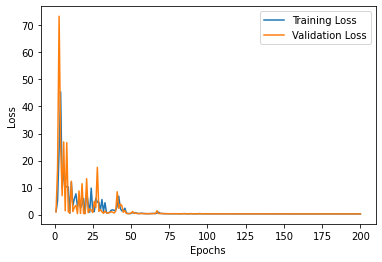

In [11]:
EPOCH = 200
train_res_recon_error = []
val_res_recon_error = []

VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)
    
    # Training loop
    for labels, inputs in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)
    
    # Validation loop (if you have a validation dataset)
    with torch.no_grad():
        running_val_loss = 0.0
        count = 0
        for labels, inputs in enumerate(test_dataloader, 0):
            inputs = inputs.to(DEVICE)
            vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
            recon_error = F.mse_loss(data_recon, inputs) / data_variance
            loss = recon_error + vq_loss
            count += 1
            running_val_loss += loss.item()
        
        # Calculate and store validation loss for this epoch
        val_loss = running_val_loss / count
        val_res_recon_error.append(val_loss)
    
    # Print and/or plot training and validation loss
    print(f"Epoch {epoch + 1}/{EPOCH}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
# Plot training and validation loss curves
epochs = np.arange(1, EPOCH + 1)
plt.plot(epochs, train_res_recon_error, label='Training Loss')
plt.plot(epochs, val_res_recon_error, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
en_lat = []
en_quantized = []
en_reconstruction = []
data_set = Mydatasets(data1 = dat)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 



#vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)


for i in range(len(dat)):
    en_data = data_set.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, data_recon, _, _,latent_2 = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat), -1)
reconstruction_out = np.array(en_quantized)
reconstruction_out = reconstruction_out.reshape(len(dat), -1)

print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

encode_out: (4445, 512)
quantized_out: (4445, 64)


# let's check if the encoding makes sense

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.6572336  0.14734906]
[40.15349   9.002246]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


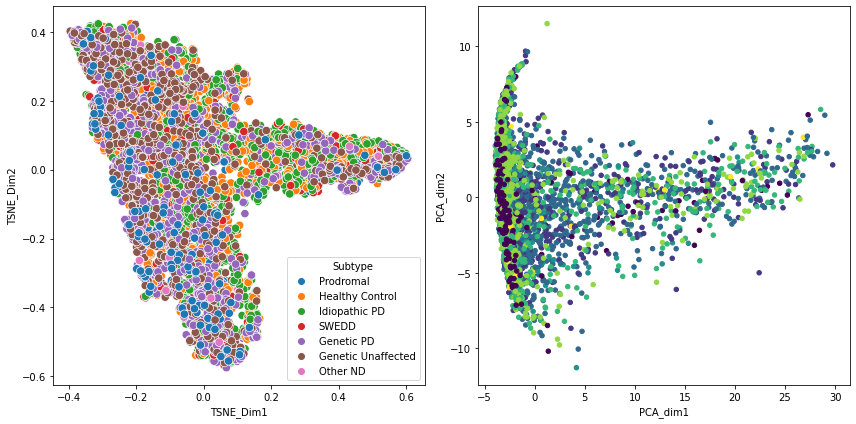

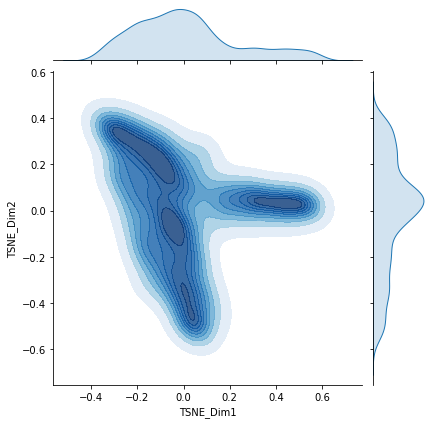

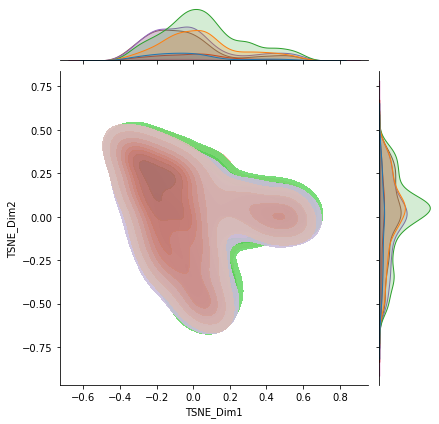

In [15]:
params = {"early_exaggeration":5,
              "learning_rate":1000, 
              "perplexity":100, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(encode_out, label, params)

In [16]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
filenames_mask = filenames_series.str.contains("BL")


# Apply the combined mask to your dataset
filtered_dat = encode_out[filenames_mask]
filtered_clinical_info = clinical_info_series[filenames_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1521, 512)
(1521,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.6522874  0.15192877]
[38.98008   9.079119]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


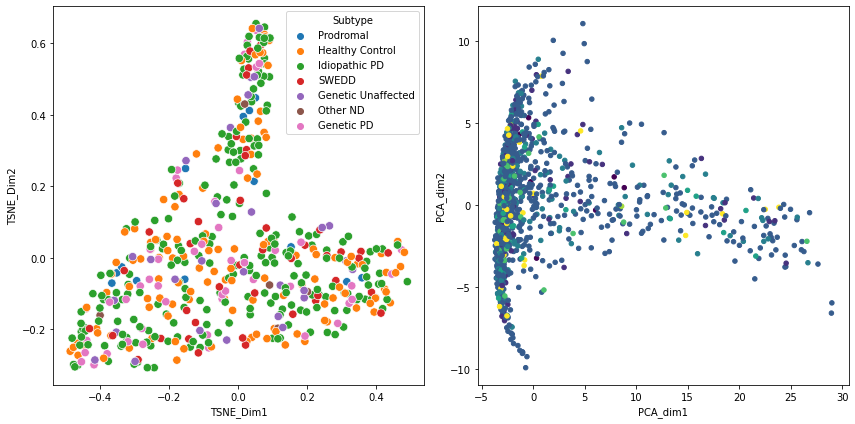

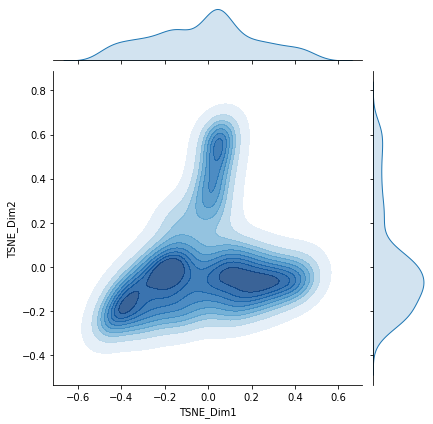

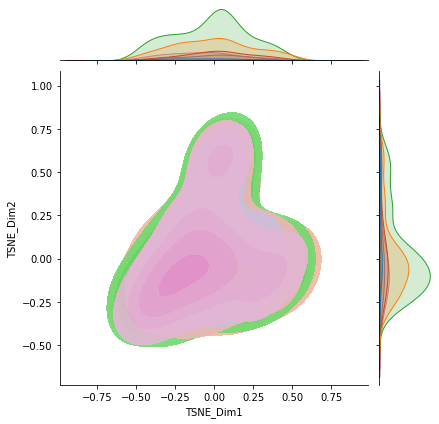

In [17]:
params = {"early_exaggeration":5,
              "learning_rate":1000, 
              "perplexity":100, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [ ]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = filenames_mask & clinical_mask

# Apply the combined mask to your dataset

filtered_dat = encode_out[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

In [ ]:
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":30, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [34]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = clinical_mask

# Apply the combined mask to your dataset

filtered_dat = encode_out[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1400, 512)
(1400,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.6833653 0.1343143]
[43.956463  8.639569]


/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


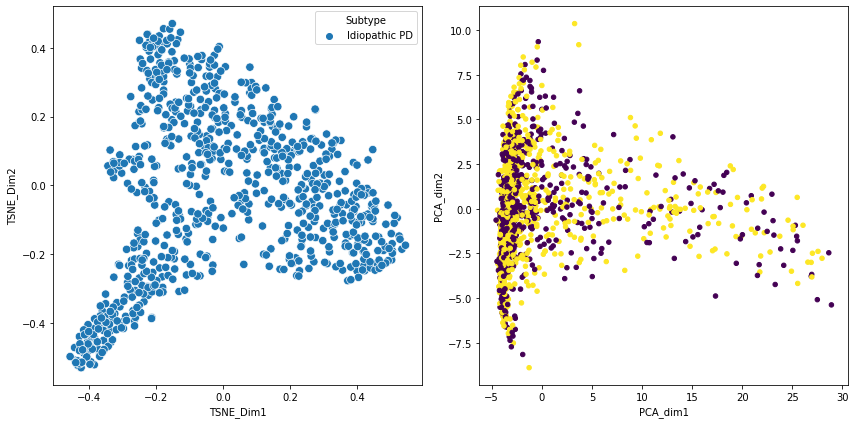

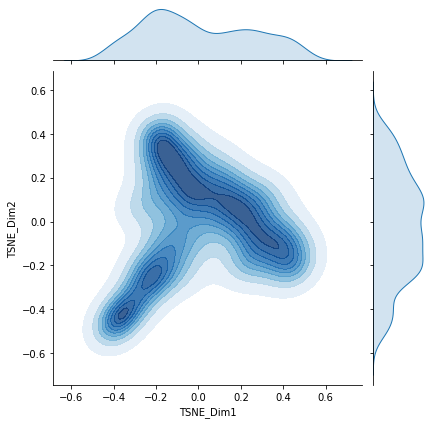

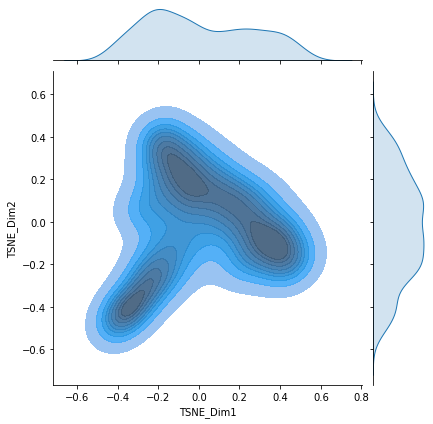

In [39]:
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":100, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

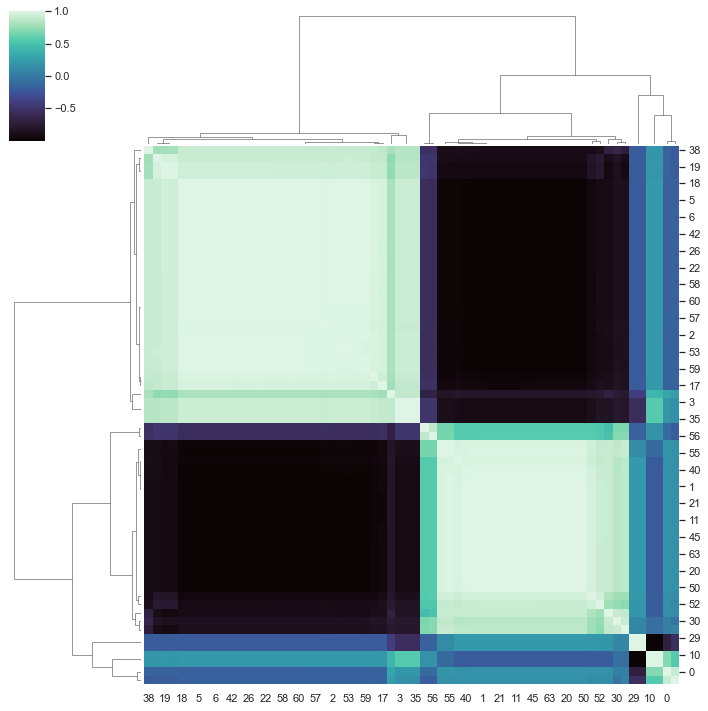

In [17]:
df = pd.DataFrame(quantized_out)
corr = df.corr(method = 'spearman')
sns.clustermap(pd.DataFrame(corr),cmap = 'mako')